Florida Atlantic University - CAP 4630 - Intro. to A.I. <br>
Dr. Marques <br>
June 21, 2023 <br>
Amparo Godoy Pastore

# Project 2: TSP using GA

## Introduction

The Traveling Salesman Problem (TSP) is a well-known optimization problem that involves finding the shortest possible route for a salesman to visit a set of cities and return to the starting city. With the number of potential routes growing exponentially, solving the TSP becomes computationally challenging. In this project, we will utilize the genetic algorithm (GA) to tackle this problem. This algorithm is an evolutionary search method inspired by natural selection. GAs iteratively generate and evolve a population of potential solutions, mimicking the processes of reproduction, crossover, and mutation. This allows us to explore different routes and gradually converge towards an optimal or suboptimal solution.

**The Problem:**

<div class="alert alert-block alert-danger" align="center">
    <b>“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”</b>
</div>


This implementation of GA to solve the TSP is similar to Eric Stoltz's OOP solution (see references). For this solution to the problem, the user enters the number of cities, and the program randomly generates their coordinates within an (x, y)
plane of 200-by-200. Although the default is 25 cities, it's important to **note that our analysis used 20 cities** to try and reduce running time for the experiment at the end. The parameters the algorithm takes are explained below in more detail.

## Preliminaries

In [29]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from IPython.display import Image

# Global seed
random.seed(123)

## Cities

***How were the cities and distances represented (as a data structure)?***

The cities the salesman travels to are represented using a class called `City`. It has three main attributes: `x`, `y`, and `id`. The `x` and `y` attributes represent the coordinates of the city on a 2D plane, defining its position within the geographical space. The `id` attribute serves as a unique identifier for each city, allowing easy identification and differentiation among multiple cities. It also has a `distance` function that utilizes the Euclidean distance formula to calculate the straight-line distance between two cities based on their coordinates.

In [2]:
# Define a class City

class City:
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id
        
    def distance(self, city):
        # Calculate the distance between two cities
        x_dis = abs(self.x - city.x)
        y_dis = abs(self.y - city.y)
        distance = np.sqrt((x_dis ** 2) + (y_dis ** 2))
        return distance
    
    def __repr__(self):
        # Return a string representation of the City object
        return "(" + str(self.id) + "," + str(self.x) + "," + str(self.y) + ")"

In [3]:
def generate_cities():
    num_cities_input = input("How many cities will the salesman travel to? (default's to 25): ")
    try:
        num_cities = int(num_cities_input)
    except ValueError:
        num_cities = 25
        
    cities = []
    for i in range(0, num_cities):
        # Create a City object with random coordinates and an ID
        cities.append(City(x=int(random.random()*200), y=int(random.random()*200), id=int(i)))
    return cities

In [4]:
# Just a function to plot the randomized cities and the best route
def plot_cities_and_route(cities, route=None):
    x = [city.x for city in cities]
    y = [city.y for city in cities]
    
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.scatter(x, y, color='red', label='Cities')
    plt.title('Cities')
    
    for city in cities:
        plt.annotate(str(city.id), (city.x, city.y), textcoords="offset points", xytext=(0,10), ha='center', va='center')
    
    if route:
        # Plotting lines connecting cities
        route_x = [city.x for city in route]
        route_y = [city.y for city in route]
        
        for i in range(len(route) - 1):
            plt.plot([route_x[i], route_x[i + 1]], [route_y[i], route_y[i + 1]], color='blue')

        # Connect last city to the first city to complete the route
        plt.plot([route_x[-1], route_x[0]], [route_y[-1], route_y[0]], color='blue')
        plt.title('Route')
    
    # Display the plot
    plt.show()

## Initial Population

***How did you encode the solution space?***

Each individual in the population is represented as a list, where each element corresponds to a unique city in the problem domain. To encode the solution space, the initial population is generated by randomly permuting the list of cities. This permutation ensures that each individual represents a distinct ordering of cities, thereby representing a potential solution or route for the traveling salesperson problem. Throughout the genetic algorithm process, the population of individuals (routes) evolves over generations, with each individual representing a distinct permutation of cities. By evaluating and evolving these permutations, the algorithm aims to find an optimal or near-optimal solution to the traveling salesperson problem.

***How did you handle the creation of the initial population?***

The creation of the initial population is handled by a function called `initial_pop`. This function generates a diverse set of initial routes (individuals) by randomly permuting the list of cities. The population size is determined by the `size` parameter passed to the function.

In [5]:
def initial_pop(size, cities, set_seed=True):
    population = []
    
    if set_seed:
        random.seed(123)
    
    for i in range(0, size):
        # Create a random route by shuffling the cities
        route = random.sample(cities, len(cities))
        population.append(route)
        
    return population

## Fitness Evaluation

***How did you compute the fitness score?***

The fitness score is computed using the `Fitness` class, which takes a route as input and calculates the fitness score based on the total distance traveled along that route. The `route_distance` method calculates the total distance traveled along the route by iterating over each city in the route. It calculates and sums the distance between consecutive cities using the `distance` function of the `City` class. The `route_fitness` method computes the fitness score based on the inverse of the route distance. It divides 1 by the total route distance, so that lower distances (shorter routes) result in higher fitness scores.

In [6]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
    
    def route_distance(self):
        if self.distance == 0:
            path_distance = 0
            for i in range(0, len(self.route)):
                from_city = self.route[i]
                to_city = self.route[(i + 1) % len(self.route)]  # Wrap around to the first city

                # Calculate the distance between two cities in the route
                path_distance += from_city.distance(to_city)
            self.distance = path_distance
        return self.distance


    
    def route_fitness(self):
        if self.fitness == 0:
            # Calculate the fitness of the route based on its distance
            self.fitness = 1 / float(self.route_distance())
        return self.fitness

## Parent Selection

***Which parent selection strategy did you use? Why?***

The parent selection strategy used is a form of Fitness Proportionate Selection, known as Roulette Wheel Selection. This strategy selects parents for mating based on their relative fitness scores. Fitter individuals have a greater pie on the wheel and therefore a greater chance of landing in front of the fixed point when the wheel is rotated. Therefore, the probability of choosing an individual depends directly on its fitness.

The `selection` function implements the parent selection process. It first ranks the individuals in the population based on their fitness scores, storing the rankings in the `pop_ranked` list. The individuals are sorted in descending order of their fitness scores, with higher fitness values indicating better solutions.

After ranking the individuals, the function constructs a cumulative probability distribution based on the fitness scores. This distribution is used to select parents by randomly sampling a value between 0 and 100. The selected value determines the position on the cumulative probability distribution, and the corresponding individual is chosen as a parent.

The reason for using fitness proportionate selection is to bias the selection towards fitter individuals while still allowing some exploration of less fit individuals. By assigning higher probabilities of selection to individuals with higher fitness scores, the algorithm focuses on exploiting promising solutions, increasing the chances of preserving and improving good traits in the offspring. This method strikes a balance between exploration and exploitation, promoting convergence towards better solutions while maintaining diversity in the population.

In [7]:
def rank_routes(population):
    fitnessResults = {}

    # Calculate fitness for each route in the population
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).route_fitness()

    # Sort the routes based on their fitness in descending order
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)

In [8]:
def selection(population, pop_ranked, num_elites):
    selection_results = []
    df = pd.DataFrame(np.array(pop_ranked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()
    
    for i in range(0, num_elites):
        # Select the elite individuals based on their rank
        selection_results.append(pop_ranked[i][0])
        
    for i in range(0, len(pop_ranked) - num_elites):
        pick = 100 * random.random()
        for i in range(0, len(pop_ranked)):
            # Perform roulette wheel selection to pick individuals based on their fitness proportion
            if pick <= df.iat[i, 3]:
                selection_results.append(pop_ranked[i][0])
                break
                
    # Create mating pool
    matingpool = []
    for i in range(0, len(selection_results)):
        index = selection_results[i]
        matingpool.append(population[index])
        
    return matingpool

## Crossover

***Which crossover strategy(ies) did you try? Which one worked out best?***

The crossover strategy used is the Order Crossover (OX) method. OX crossover is a permutation-based crossover operator specifically designed for the traveling salesperson problem. The `ox_crossover` function implements this by taking two parent routes as input and generating a child route, partially preserving the order of cities from one parent and filling the remaining cities from the other parent.


In [9]:
def ox_crossover(parents, num_elites):
    offspring = []
    length = len(parents) - num_elites
    pool = random.sample(parents, len(parents))
    
    for i in range(0, num_elites):
        # Add elite parents to the offspring
        offspring.append(parents[i])
    
    for i in range(0, length):
        parent1 = pool[i]
        parent2 = pool[len(parents) - i - 1]
        
        # Perform crossover between parent1 and parent2
        child = []
        childP1 = []
        childP2 = []
        
        geneA = int(random.random() * len(parent1))
        geneB = int(random.random() * len(parent1))
        
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
    
        for j in range(startGene, endGene):
            childP1.append(parent1[j])
            
        childP2 = [item for item in parent2 if item not in childP1]
    
        child = childP1 + childP2
        
        # Add the child to the offspring
        offspring.append(child)
        
    return offspring

## Mutation

***Which mutation strategy(ies) did you try? Which one worked out best?***

The swap mutation strategy used selects two positions (cities) on the chromosome (route) at random, and interchange the values. It is implemented by the `mutate` function, which iterates over the individual's route and, with a certain probability (determined by the `mutation_rate`) swaps the current city with another randomly selected city in the route.

In [10]:
def mutate(individual, mutation_rate):
    for swapped in range(len(individual)):
        if random.random() < mutation_rate:
            # Randomly swap cities within the individual
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [11]:
def mutate_population(population, mutation_rate):
    mutated_pop = []
    
    for ind in range(0, len(population)):
        # Mutate each individual in the population
        mutated_ind = mutate(population[ind], mutation_rate)
        mutated_pop.append(mutated_ind)
        
    return mutated_pop

## Next Generation

***Which strategy did you use for populating the next generation? Why?***

To populate the next generation we used Elitism as the survivor selection technique. A certain number of top individuals from the current generation are passed on to the next generation based on their fitness scores. Elitism helps preserve the best solutions discovered so far and ensures they have a chance to propagate to subsequent generations. Offspring is generated for the remaining positions in the next generation through crossover.

In [12]:
def next_gen(curr_gen, num_elites, mutation_rate):
    pop_ranked = rank_routes(curr_gen)
    matingpool = selection(curr_gen, pop_ranked, num_elites)
    offspring = ox_crossover(matingpool, num_elites)
    next_gen = mutate_population(offspring, mutation_rate)
    return next_gen

## Genetic Algorithm


***Which stopping condition did you use? Why?***

The code specifies a maximum number of generations, as well as a maximum stagnation value, that is, the number of generations for which there has been no improvement in the population. By using the stagnation stopping condition, the algorithm can avoid unnecessary iterations and improve its efficiency. However, if the stagnation condition is not met, the algorithm will run for the specified number of generations.

In [13]:
def genetic_algorithm(population, pop_size, num_elites, mutation_rate, generations, max_stagnation, print_results=True, set_seed=True):
    
    if print_results:
        # Print the parameters used
        print("Genetic Algorithm Parameters:")
        print(f"Number of Cities: {len(population)}")
        print(f"Population Size: {pop_size}")
        print(f"Number of Elites: {num_elites}")
        print(f"Mutation Rate: {mutation_rate}")
        print(f"Number of Generations: {generations}")
        print(f"Max Stagnation: {max_stagnation}")
        print("-----------------------------")
    
    if set_seed:
        curr_gen = initial_pop(pop_size, population)  # List of initial possible routes
    else:
        curr_gen = initial_pop(pop_size, population, set_seed=False)  # List of initial possible routes
    initial_distance = 1 / rank_routes(curr_gen)[0][1]  # Initial best distance

    best_fitness = rank_routes(curr_gen)[0][1]  # Best fitness score in the initial generation
    stagnation_count = 0  # Counter for tracking the number of generations without improvement
    
    progress = []  # List to store the progression of distances
    
    for i in range(0, generations):
        # Generate the next generation
        curr_gen = next_gen(curr_gen, num_elites, mutation_rate)
        
        # Check if the best fitness score has improved
        if rank_routes(curr_gen)[0][1] > best_fitness:
            best_fitness = rank_routes(curr_gen)[0][1]
            stagnation_count = 0
        else:
            stagnation_count += 1
        
        # Check if there has been no improvement for max_stagnation iterations
        if stagnation_count >= max_stagnation:
            if print_results:
                print("\nTerminating due to stagnation...\n")
            break
        
        # Calculate and append the best distance to the progress list
        best_distance = 1 / rank_routes(curr_gen)[0][1]
        progress.append(best_distance)
    
    final_distance = 1 / rank_routes(curr_gen)[0][1]  # Final best distance
    
    # Get the best route from the final generation
    bestRouteIndex = rank_routes(curr_gen)[0][0]
    bestRoute = curr_gen[bestRouteIndex]
    
    if print_results:
        print(f"Initial distance: {initial_distance}")
        print(f"Final distance: {final_distance}")
        print("Optimal route: ", [city.id for city in bestRoute])
    
    return bestRoute, progress, initial_distance, final_distance

Now, we create a function to record inputs and outputs into a dataframe. This will allow us to run some experiments and easily compare the outcomes.

In [14]:
def record_experiment(params, initial_distance, final_distance, solution):
    # Create a df to store the experiment results
    df = pd.DataFrame(columns=['Population Size', 'Number of Elites', 'Mutation Rate', 'Number of Generations', 'Max Stagnation', 'Initial Distance', 'Final Distance', 'Best Route (city ID)'])

    # Prepare the data to be inserted into the df
    data = {
        'Population Size': params['pop_size'],
        'Number of Elites': params['num_elites'],
        'Mutation Rate': params['mutation_rate'],
        'Number of Generations': params['generations'],
        'Max Stagnation': params['max_stagnation'],
        'Initial Distance': [initial_distance],
        'Final Distance': [final_distance],
        'Best Route (city ID)': [','.join(str(city.id) for city in solution)]
    }

    # Concatenate the data into a new df
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

    return df

## Running the Genetic Algorithm

First, let us run the algorithm to ensure it works properly. Here, we generate the list of city objects, and plot their distribution and IDs. 

How many cities will the salesman travel to? (default's to 25): 20


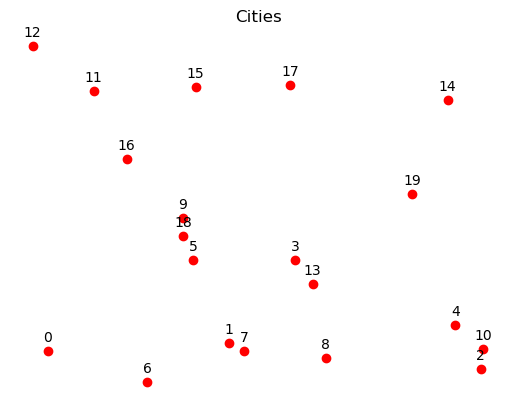

In [15]:
# Generate cities 
cities = generate_cities()

# Plot them
plot_cities_and_route(cities)

***What other parameters, design choices, initialization and configuration steps are relevant to your design and implementation?***

The function `genetic_algorithm`is called with several parameters:

- `population`: The population of cities on which the genetic algorithm will operate. It is passed as the cities list, which contains the initial set of cities.

- `pop_size`: The size of the population, i.e., the number of individuals (routes) in each generation of the genetic algorithm.

- `num_elites`: The number of top-performing individuals (elite parents) that will be preserved in each generation without undergoing crossover or mutation. These elites have the best fitness values and help maintain the best solutions throughout the generations.

- `mutation_rate`: The probability of mutation for each gene (city) in an individual (route) during the genetic algorithm. A higher mutation rate increases the exploration of the solution space by introducing random changes.

- `generations`: The total number of generations or maximum number of iterations for which the genetic algorithm can run.

- `max_stagnation`: The maximum number of consecutive generations without any improvement in the population's fitness (stagnation). If the population fails to show improvement for this number of generations, the algorithm terminates early.

- `print_results`: True by default. Set to False to not print results to screen.

- `set_seed`: True by default. Set to False to get a randomized initial population every run (all other values constant). 

We will be introducing variations to these parameters later on to test their effect on the algorithm. For now, we are only focusing on testing whether the algorithm effectively reduces distance over the generations.

In [28]:
# Generate cities 
cities = generate_cities()

# Set the parameters 
params = {
    'pop_size': 100,
    'num_elites': 20,
    'mutation_rate': 0.01,
    'generations': 500,
    'max_stagnation': 100
}

# Run the algorithm
solution, progression, ini_d, fin_d = genetic_algorithm(population=cities, **params, set_seed=False)

How many cities will the salesman travel to? (default's to 25): 10
Genetic Algorithm Parameters:
Number of Cities: 10
Population Size: 100
Number of Elites: 20
Mutation Rate: 0.01
Number of Generations: 500
Max Stagnation: 100
-----------------------------

Terminating due to stagnation...

Initial distance: 640.6857133206012
Final distance: 502.1045250249281
Optimal route:  [5, 4, 9, 7, 3, 2, 1, 8, 0, 6]


The results above indicate that the genetic algorithm was able to find an optimized route that minimized the distance traveled among the given set of cities. The algorithm's performance demonstrates its effectiveness in solving the traveling salesman problem.

## Plot Optimal Route

Let's visualize the solution, represented below by the blue line connecting the red dots.

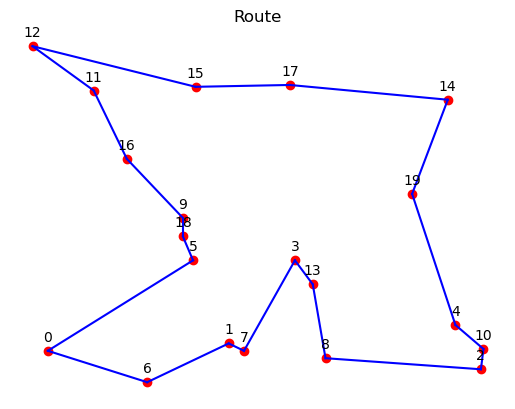

In [17]:
plot_cities_and_route(cities, route=solution)

## Plot Progress

The following graph shows how route distance changes over the generations. As we can see, it drops significantly over the first 50 generations and then continues to decrease at a slower pace. The graph also shows the stagnation period that terminated the algorithm before it reached the 500 generation mark.

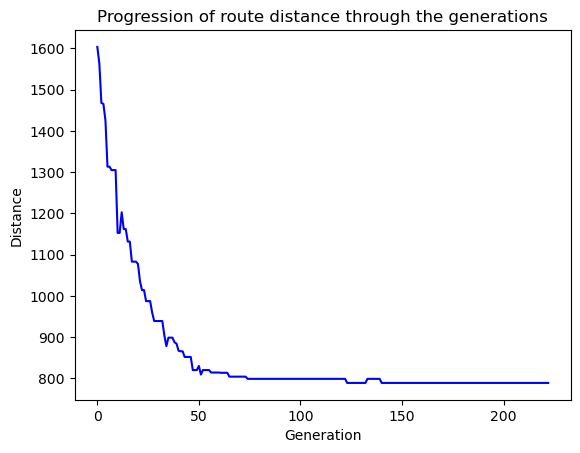

In [18]:
# Plot progression of route distance through the generations
plt.plot(progression, color='blue')
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.title('Progression of route distance through the generations')
plt.show()

## Experiments 1 & Results

***Which (simple) experiments have you run to observe the impact of different design decisions and parameter values? Post their results and your comments***

In this section, we present the experimental results of running the genetic algorithm (GA) with various parameter combinations for the optimization problem at hand. The purpose of this experimentation is to investigate the impact of different parameter settings on the performance of the GA. Specifically, we aim to determine how variations in population size, number of elites, mutation rate, number of generations, and maximum stagnation affect the algorithm's ability to find optimal or near-optimal solutions.

To accomplish this, we conducted multiple runs of the GA, each time using a different set of parameter values. The algorithm was applied to a diverse set of problem instances, and the resulting solutions were evaluated based on the initial and final distances achieved. It is important to note that we did not explicitly capture additional statistics such as the number of generations required to reach a near-optimal solution or whether the algorithm terminated due to stagnation. We recorded the experimental results, including the parameter settings, initial distance, final distance, and the obtained solution, for each run.

In [19]:
# Define the parameter combinations to run our experiment
parameter_combinations = [
    {'pop_size': 100, 'num_elites': 20, 'mutation_rate': 0.01, 'generations': 500, 'max_stagnation': 100}, # Control or baseline
    {'pop_size': 30, 'num_elites': 20, 'mutation_rate': 0.01, 'generations': 500, 'max_stagnation': 100},
    {'pop_size': 200, 'num_elites': 20, 'mutation_rate': 0.01, 'generations': 500, 'max_stagnation': 100},
    {'pop_size': 100, 'num_elites': 3, 'mutation_rate': 0.01, 'generations': 500, 'max_stagnation': 100},
    {'pop_size': 100, 'num_elites': 50, 'mutation_rate': 0.01, 'generations': 500, 'max_stagnation': 100},
    {'pop_size': 100, 'num_elites': 20, 'mutation_rate': 0.001, 'generations': 500, 'max_stagnation': 100},
    {'pop_size': 100, 'num_elites': 20, 'mutation_rate': 0.1, 'generations': 500, 'max_stagnation': 100},
    {'pop_size': 100, 'num_elites': 20, 'mutation_rate': 0.01, 'generations': 250, 'max_stagnation': 100},
    {'pop_size': 100, 'num_elites': 20, 'mutation_rate': 0.01, 'generations': 1000, 'max_stagnation': 100},
    {'pop_size': 100, 'num_elites': 20, 'mutation_rate': 0.01, 'generations': 500, 'max_stagnation': 10},
    {'pop_size': 100, 'num_elites': 20, 'mutation_rate': 0.01, 'generations': 500, 'max_stagnation': 200},
    {'pop_size': 30, 'num_elites': 3, 'mutation_rate': 0.001, 'generations': 250, 'max_stagnation': 10},
    {'pop_size': 200, 'num_elites': 50, 'mutation_rate': 0.1, 'generations': 1000, 'max_stagnation': 200}
]

In [20]:
# Initialize an empty df
experiment_df = pd.DataFrame()

# Iterate over the parameter combinations
for params in parameter_combinations:
    # Run the genetic algorithm
    solution, progression, initial_distance, final_distance = genetic_algorithm(population=cities, **params, print_results=False)

    # Record the experiment
    experiment_row = record_experiment(params, initial_distance, final_distance, solution)

    # Append the experiment row to the df
    experiment_df = pd.concat([experiment_df, experiment_row], ignore_index=True)

# Save the df to a csv file
experiment_df.to_csv('experiment_results.csv', index=False)

In [21]:
# Retrieve the df from the csv file
experiment_df = pd.read_csv('experiment_results.csv')

# Print it
experiment_df

,Population Size,Number of Elites,Mutation Rate,Number of Generations,Max Stagnation,Initial Distance,Final Distance,Best Route (city ID)
0,100,20,0.010,500,100,1603.173187,789.256345,"10,4,19,14,17,15,12,11,16,9,18,5,0,6,1,7,3,13,8,2"
1,30,20,0.010,500,100,1798.556840,1052.827330,"4,8,1,13,18,9,0,6,7,5,11,12,15,16,17,14,19,3,2,10"
2,200,20,0.010,500,100,1603.173187,789.256345,"4,19,14,17,15,12,11,16,9,18,5,0,6,1,7,3,13,8,2,10"
3,100,3,0.010,500,100,1603.173187,803.635037,"6,0,5,18,9,16,12,11,15,17,14,19,4,2,10,8,13,3,7,1"
4,100,50,0.010,500,100,1603.173187,773.841527,"10,4,13,3,19,14,17,15,12,11,16,9,18,5,0,6,1,7,8,2"
5,100,20,0.001,500,100,1603.173187,773.841527,"10,4,13,3,19,14,17,15,12,11,16,9,18,5,0,6,1,7,8,2"
6,100,20,0.100,500,100,1603.173187,1496.050442,"10,6,0,14,12,11,16,18,15,17,13,9,4,2,8,5,1,7,3,19"
7,100,20,0.010,250,100,1603.173187,789.256345,"10,4,19,14,17,15,12,11,16,9,18,5,0,6,1,7,3,13,8,2"
8,100,20,0.010,1000,100,1603.173187,789.256345,"10,4,19,14,17,15,12,11,16,9,18,5,0,6,1,7,3,13,8,2"
9,100,20,0.010,500,10,1603.173187,813.801423,"4,2,10,19,14,17,15,12,11,16,9,18,5,0,6,7,1,8,13,3"


For our experiment we first run the algorithm with "baseline" parameters, inspired by Eric Stoltz's solution. Each run after that, isolates a parameter by increasing and decreasing it to evaluate its effect. The last two runs decrease and increase all values respectively (both yielding suboptimal results). Again, please note that we used 20 cities for our test.

Analyzing the results, we can observe that different parameter combinations lead to varying levels of success in finding shorter routes. The baseline (run 0), with a population size of 100, 20 elites and a mutation rate of 0.01 resulted in a significant improvement, reducing the initial distance of 1603.17 to a final distance of 789.26. On the other hand, in row 6, a higher mutation rate of 0.1 caused the algorithm to struggle, resulting in a less optimal solution with a final distance of 1496.05. 

These results demonstrate the sensitivity of the genetic algorithm to the choice of parameters and highlight the importance of fine-tuning them to achieve the best performance. By systematically exploring different parameter combinations, it is possible to find configurations that lead to significant improvements in finding shorter routes.

## Experiments 2 & Representative Screenshots

Here we set seed to False, and run the algorithm with different numbers of cities.

| ***RUN 1***     | ***RUN 2***     |
|-----------------|-----------------|
| ![image-11.png](Screenshot%202023-06-21%20181801.png) | ![image-7.png](Screenshot%202023-06-21%20182433.png) |

| ***RUN 3***     | ***RUN 4***     |
|-----------------|-----------------|
| ![image-8.png](Screenshot%202023-06-21%20182527.png)  | ![image-9.png](Screenshot%202023-06-21%20182634.png)  |

| ***RUN 5***     |
|-----------------|
| ![image-10.png](Screenshot%202023-06-21%20182756.png) |

## Future Improvements

While the current implementation of the genetic algorithm has shown promising results in solving the traveling salesman problem, there are several potential areas of improvement. Two of the most interesting ones are:

1. **Dynamic Parameter Adaptation:** The use of dynamic parameter adaptation techniques during the execution of the genetic algorithm based on the evolving characteristics of the population or problem instance can potentially enhance the algorithm's performance and adaptability across different problem domains.

2. **Real-world Dataset Evaluation:** This involves evaluating the performance of the genetic algorithm on real-world datasets of varying sizes and complexities and it would provide insights into its generalization capabilities and highlight potential areas for improvement or adaptation.

## References

- Golinko, Eric. "Evolution of a Salesman: A Complete Genetic Algorithm Tutorial for Python." Towards Data Science, [https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35]


- "Genetic Algorithms - Introduction." Tutorialspoint, [https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_introduction.htm]


- "Travelling Salesman Problem." Wikipedia, [https://en.wikipedia.org/wiki/Travelling_salesman_problem]


